In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'    # GPU No.
from sampler.utils import *
from trainer.utils import restore_checkpoint
import torch
import torch.nn as nn
import json
from collections import namedtuple
from tqdm import tqdm

from models import get_model, get_ema
from sampler import VESDE
import numpy as np
from einops import rearrange

data_name = 'kse'
version = 'v0'      
opt_path = './results/' + data_name + '_' + version + '/config.json'
with open(opt_path, 'r', encoding='utf-8') as f:
    opt = json.load(f)
    opt['num_channels'] = opt['num_components'] + opt['num_conditions']
OPT_class = namedtuple('OPT_class', opt.keys())
opt = OPT_class(**opt)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2024-10-18 16:18:04.160834: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Load pretrained model

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = get_model(opt)
net = nn.DataParallel(net)
net.to(device)
ema = get_ema(net.parameters(), decay=opt.ema_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=opt.lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
state = dict(optimizer=optimizer, model=net, ema=ema, epoch=0, iteration=0, loss_train=[])

ckpt_path = opt.results_path + '/checkpoint.pth'

state = restore_checkpoint(ckpt_path, state, device)
net = state['model']
ema = state['ema']
ema.copy_to(net.parameters())
print('Model loaded from epoch', state['epoch'])

Model loaded from epoch 300


# Load test data

In [3]:
data_test_path = "./data/kse/KSE_test.npy"
scalar_path = opt.results_path + '/scalar.npy'
data_raw = np.load(data_test_path)
params = np.array([1.1, 2.5, 3.2])
x_test = data_raw.reshape(3, 3, 106, 1024, 1)
mean, std = np.load(scalar_path)
scalar = lambda x: (x-mean)/std
scalar_inv = lambda x: x*std+mean

# Load test data

In [4]:
m           =   2                                       # overlap
T           =   opt.num_frames                          # number of frames within a single sample
T_prime     =   100                                     # length of frames you want to generate
B           =   int(np.ceil((T_prime-m) / (T - m)))     # number of samples for parallel generation
T_prime     =   B * (T - m) + m                         # the total length might be a little longer than the given length
n_samples   =   1                                       # batch size

samples = []
seed_samples = 1
rnd = np.random.RandomState(seed_samples)
num_init = len(x_test)
num_params = len(x_test[0])
s_init, s_param = 0, 0

'''experimental samples'''
indices = []
for i_init, tr_init in enumerate(x_test):
    for i_param, tr in enumerate(tr_init):
        single_sample = x_test[i_init, i_param, :T_prime].transpose(0, 2, 1)
        param = (params[i_param]-3)/4. * np.ones_like(single_sample)
        samples.append(np.concatenate([single_sample, param], axis=1))
samples = np.stack(samples, axis=0)         # b*(t*c+2)*h*w
samples = samples[[s_init*num_params+s_param]]
print(samples.shape)

(1, 106, 2, 1024)


# Reconstruction

In [5]:
outer_loop = 1000    # predictor steps

seed_sample = 123

obs_type = 'random'     # 'random', 'regular', 'forecast'
scale = 0.98            # scale is: mask ratio (float between 0 and 1, e.g., 0.98) for 'random', down-sampling rate (int, e.g., 64) for 'regular', number of initial frames (int, e.g., 2) for 'forecast'

# hyperparameters for generating stage
alpha_case = 0.5        # 0.5
beta = 0.4              # 0.4
gamma = 0.5             # 0.5

'''for Kolmogorov flow'''
sde = VESDE(opt, sigma_min=opt.beta_min, sigma_max=opt.beta_max, N=outer_loop)
net.eval()
reap_fn = lambda x, num: torch.stack([x for _ in range(num)])

setup_seed(seed_sample)
with torch.no_grad():
    if obs_type.lower() == 'random':
        '''randomly located observation'''
        T_prime_y = T_prime                      # sequence that is dependent on observation
        mask = np.zeros([T_prime_y, opt.num_components+opt.num_conditions, opt.image_size])
        mask[:, :opt.num_components] = mask_gen([T_prime_y, 1, opt.image_size], scale, seed=seed_samples)
        mask_torch = torch.from_numpy(mask).to(device)
        transform_gen = transform = lambda x:x[:, :T_prime_y]*mask[np.newaxis,] if isinstance(x, np.ndarray) else x[:, :T_prime_y]*mask_torch[None,].to(x.device)   # only the observable frames are given
        sparsity = scale        # calculate sparsity of each task
    elif obs_type.lower() == 'regular':
        '''regularly located observation'''
        T_prime_y = T_prime
        transform_gen = transform = lambda x:x[:, :T_prime_y, :1, ::scale]     # only the observable frames are given
        sparsity = 1-1/scale    # calculate sparsity of each task
    elif obs_type.lower() == 'forecast':
        T_prime_y = 0
        transform_gen = transform = lambda x:x[:, :scale]
        sparsity = 1-scale/T    # calculate sparsity of each task

    alpha = alpha_case/np.sqrt(1-sparsity)
    
    samples_scale = samples.copy()
    samples_scale[:, :, :opt.num_components] = scalar(samples_scale[:, :, :opt.num_components])
    y = transform_gen(samples_scale)
    print(y.shape)

    latent_mask = torch.ones([T, 1, 1]).float().to(device)
    obs_mask = torch.zeros([T, 1, 1]).float().to(device)
    frame_indices = torch.arange(T).to(device)
    net_fn = lambda x, t: net(x, x0=x, timesteps=t, latent_mask=reap_fn(latent_mask, len(x)), obs_mask=reap_fn(obs_mask, len(x)), frame_indices=reap_fn(frame_indices, len(x)))[0]

    x_inpainted = s3gm_sample_1d(opt, net_fn, sde, y,
                              transform_gen,
                              alpha=alpha, beta=beta, gamma=gamma,
                              T_prime_y=T_prime_y, T_prime=T_prime, overlap=m,
                              corrector=NoneCorrector,
                              snr=0.128, device=device, dtype='float', eps=1e-12,
                              probability_flow=False, continuous=True,)

x_pred = x_inpainted
x_pred[:, :, :opt.num_components] = scalar_inv(x_pred[:, :, :opt.num_components])
num_T = x_pred.shape[1]
print(f'Number of generated snapshots: {num_T}')
torch.cuda.empty_cache()

(1, 106, 2, 1024)


  0%|          | 0/1000 [00:00<?, ?it/s]

loss total: 2.69838e-01 | loss dps: 8.08348e-02 | loss consis: 1.39074e-01: 100%|██████████| 1000/1000 [02:06<00:00,  7.92it/s]


Number of generated snapshots: 106


# Visualization

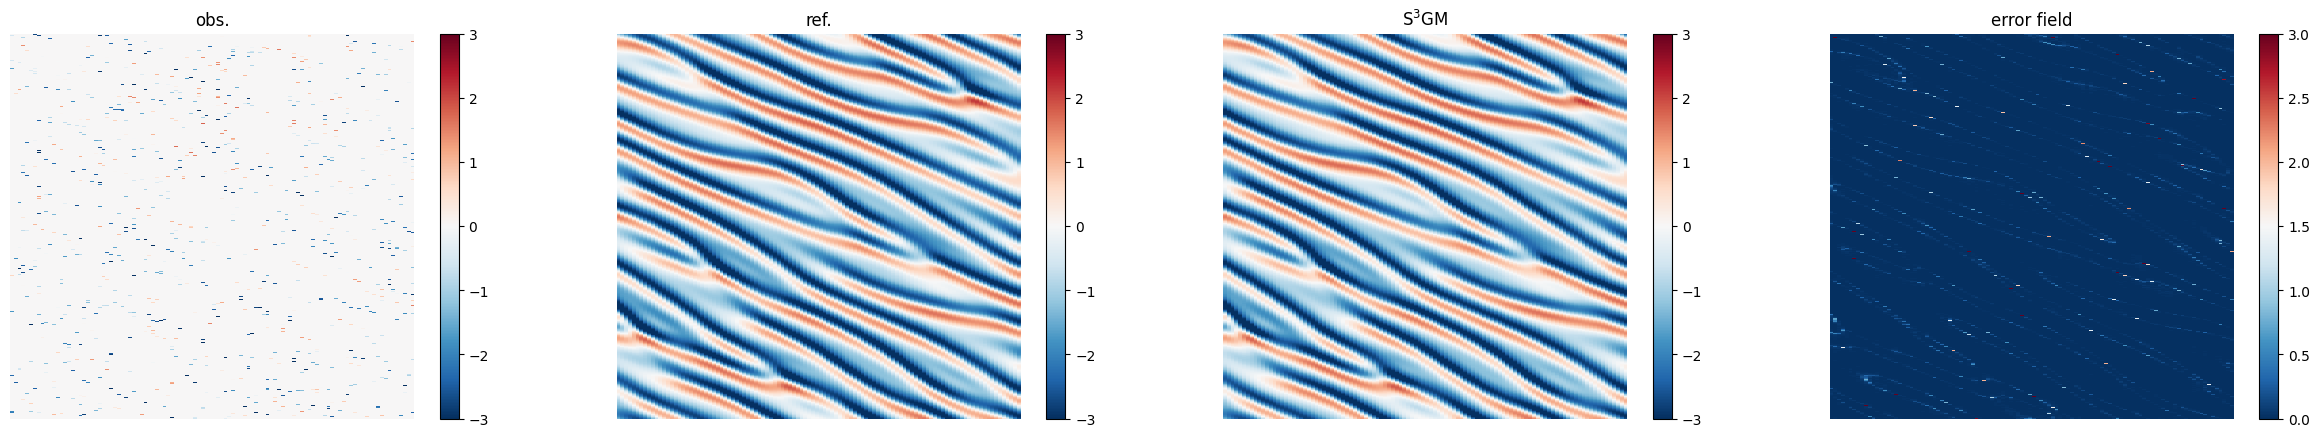

In [7]:
from einops import rearrange
ib = 0
y_plot = np.zeros_like(samples)
if 'forecast' in obs_type:
    y_plot[:, :m] = samples[:, :m]
elif 'regular' in obs_type:
    y_plot = y_plot[..., :y.shape[-1]]
    y_plot[:, :y.shape[1], :1, :] = y
else:
    y_plot[:, :y.shape[1]] = y
plt.figure(figsize=(30, 5))
plt.subplot(141)
plt.pcolormesh(y_plot[ib, :, 0].transpose(), cmap='RdBu_r', vmin=-3, vmax=3)    # , vmin=1, vmax=2
plt.gca().axis('off')
plt.title('obs.')
plt.colorbar()
plt.subplot(142)
plt.pcolormesh(samples[ib, :, 0].transpose(), cmap='RdBu_r', vmin=-3, vmax=3)    # , vmin=1, vmax=2
plt.gca().axis('off')
plt.title('ref.')
plt.colorbar()
plt.subplot(143)
plt.pcolormesh(x_pred[ib, :, 0].transpose(), cmap='RdBu_r', vmin=-3, vmax=3)    # , vmin=1, vmax=2
plt.gca().axis('off')
plt.title('S$^3$GM')
plt.colorbar()
plt.subplot(144)
plt.pcolormesh((np.sqrt((samples[ib, :, 0]-x_pred[ib, :, 0])**2)/(np.abs(samples[ib, :, 0])+1e-8)).transpose(), cmap='RdBu_r', vmin=0, vmax=3)    # , vmin=1, vmax=2
plt.colorbar()
plt.gca().axis('off')
plt.title('error field')
plt.show()

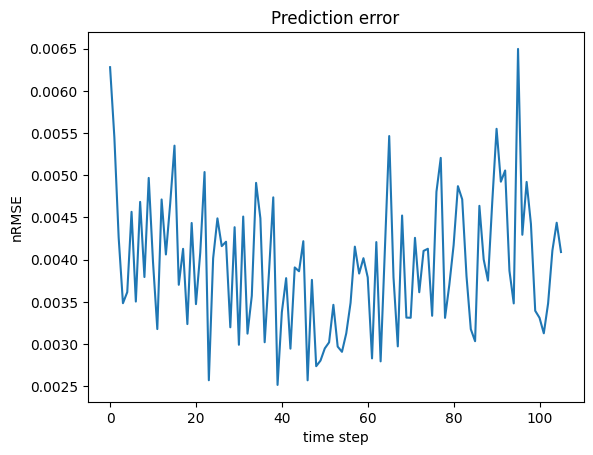

In [8]:
errors = cal_rmse(samples[0], x_pred[0], normalize=True)
plt.plot(errors)
plt.xlabel('time step')
plt.ylabel('nRMSE')
plt.title('Prediction error')
plt.show()